In [1]:
# Libraries

import argparse
import os
import platform
import ray
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tuner

ray.init(include_dashboard = False)

from ray.tune import choice
from ray.tune import uniform
from ray.tune import loguniform
from ray.tune import randint
from ray.tune import grid_search

2023-03-27 18:12:36,527	INFO worker.py:1538 -- Started a local Ray instance.


In [4]:
# Code

from source.python.raytune import raytune_data
from source.python.raytune import raytune_model
from source.python.raytune import raytune_plot
from source.python.raytune import raytune_utils
from source.python.io      import loader
from source.python         import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [5]:
# Define output and inputs

MODEL_NAME       = 'zrimec2020'
MODEL_TYPE       = 'c'
MODEL_MODE       = None
MODEL_PARAMS     = None
MODEL_EPOCHS     = 5

TARGET_GROUP     = 'global'
TARGET_TYPE      = 'mean'
TARGET_EXPLODE   = False
TARGET_FILTER    = None

TUNER_CONCURRENT = 1
TUNER_TRIALS     = 5
TUNER_GRACE      = 1
TUNER_NOTEBOOK   = True
TUNER_SEARCH     = 'gridsearch'

In [6]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')

	parser = argparse.ArgumentParser()

	str_of_bool = lambda x : True if x == 'true' else False
	str_or_none = lambda x : None if x == 'none' else str(x)

	_target_groups = ['tissue', 'group', 'age', 'global', 'perturbation']
	_target_types  = ['mean', 'max']
	_model_names   = ['washburn2019', 'zrimec2020']
	_model_types   = ['r', 'c']
	_tuner_search  = ['hyperopt', 'gridsearch']

	parser.add_argument('--target_group',     type = str,         default = 'global',     choices = _target_groups)
	parser.add_argument('--target_type',      type = str,         default = 'mean',       choices = _target_types)
	parser.add_argument('--target_explode',   type = str_of_bool, default = False)
	parser.add_argument('--target_filter',    type = str_or_none, default = None)
	parser.add_argument('--model_name',       type = str,         default = 'zrimec2020', choices = _model_names)
	parser.add_argument('--model_type',       type = str,         default = 'r',          choices = _model_types)
	parser.add_argument('--model_epochs',     type = int,         default = 500)
	parser.add_argument('--tuner_search',     type = str,         default = 'hyperopt',   choices = _tuner_search)
	parser.add_argument('--tuner_concurrent', type = int,         default = 5)
	parser.add_argument('--tuner_trials',     type = int,         default = 250)
	parser.add_argument('--tuner_grace',      type = int,         default = 5)

	args = vars(parser.parse_args())

	TARGET_GROUP     = args['target_group']
	TARGET_TYPE      = args['target_type']
	TARGET_EXPLODE   = args['target_explode']
	TARGET_FILTER    = args['target_filter']
	MODEL_NAME       = args['model_name']
	MODEL_TYPE       = args['model_type']
	MODEL_EPOCHS     = args['model_epochs']
	TUNER_CONCURRENT = args['tuner_concurrent']
	TUNER_TRIALS     = args['tuner_trials']
	TUNER_GRACE      = args['tuner_grace']
	TUNER_SEARCH     = args['tuner_search']
	TUNER_NOTEBOOK   = False

if TARGET_GROUP == 'global' :
	TARGET_EXPLODE = False

if MODEL_TYPE == 'r' : MODEL_MODE = 'regression'
if MODEL_TYPE == 'c' : MODEL_MODE = 'classification'

Running as .ipynb


In [7]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', 'data', MODEL_NAME[:-4])
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\zrimec
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\data\zrimec\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 21.598 GB


# 2. Tuner

In [9]:
# Define basic data parameters

CONFIG = {
	'core/random'             : None,
	'core/device'             : DEVICE,
	'core/rootdir'            : ROOT,
	'core/outdir'             : OUT_DATA,
	'dataset/filepath'        : os.path.join(OUT_DATA, 'dataset.pkl'),
	'dataset/expanddim'       : None,
	'dataset/split/valid'     : 0.2,
	'dataset/split/test'      : 0.2,
	'tuner/trials'            : TUNER_TRIALS,
	'tuner/max_epochs'        : MODEL_EPOCHS,
	'tuner/min_epochs'        : TUNER_GRACE,
	'tuner/max_concurrent'    : TUNER_CONCURRENT,
	'tuner/reporter/freq'     : 30,
	'tuner/reporter/notebook' : TUNER_NOTEBOOK,
	'tuner/checkpoint'        : False,
	'tuner/stopper'           : True,
	'tuner/stopper/days'      : 3,
	'tuner/stopper/hours'     : 22,
	'tuner/stopper/minutes'   : 0,
	'tuner/search'            : TUNER_SEARCH,
	'model/name'              : MODEL_NAME,
	'model/type'              : MODEL_NAME + MODEL_TYPE,
	'model/mode'              : MODEL_MODE,
	'model/epochs'            : MODEL_EPOCHS,
	'model/input/channels'    : 1,
	'model/input/height'      : 4,
	'model/input/width'       : 2150,
	'model/input/features'    : None,
	'model/output/target'     : TARGET_GROUP,
	'model/output/type'       : TARGET_TYPE,
	'model/output/filter'     : TARGET_FILTER,
	'model/output/explode'    : TARGET_EXPLODE,
	'model/output/size'       : None,
	'model/output/heads'      : None,
	'params/tuner'            : None,
	'params/filepath'         : RES_TUNER
}

CONFIG['core/random'] = runtime.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/name'].startswith('washburn2019') :
	CONFIG['dataset/expanddim'] = 0

In [10]:
# Prints

print('Model Name  : {}'.format(CONFIG['model/name']))
print('Model Type  : {}'.format(CONFIG['model/type']))
print('Model Mode  : {}'.format(CONFIG['model/mode']))
print('Random Seed : {}'.format(CONFIG['core/random']))

Model Name  : zrimec2020
Model Type  : zrimec2020c
Model Mode  : classification
Random Seed : 342137597


# 3. Search Space

In [11]:
# Define search space

param_space = dict()

param_space['boxcox/lambda'] = uniform(-1.0, 0.5)
param_space['class/bins']    = randint(2, 10)

if CONFIG['tuner/search'] == 'gridsearch' :
	param_space['class/bins'] = grid_search(list(range(2, 5)))

# 4. Tuning

In [12]:
# Create tuner config

trainable = raytune_utils.create_trainable(
	method    = raytune_data.main,
	config    = CONFIG,
	cpu_count = SYSTEM['platform/cpu/count'],
	gpu_count = SYSTEM['platform/gpu/count']
)

tune_config = raytune_utils.create_tune_config(
	config    = CONFIG,
	algorithm = CONFIG['tuner/search'],
	params = [
		{'boxcox/lambda' : -0.14552661101589698, 'class/bins' : 3},
		{'boxcox/lambda' :  0.00000000000000000, 'class/bins' : 3}
	]
)

run_config = raytune_utils.create_run_config(
	config    = CONFIG,
	local_dir = OUT_DATA,
	verbosity = raytune_utils.VERBOSE_STATUS,
	task      = 'data'
)

In [13]:
# Create tune and fit

tuner = raytune_utils.create_tuner(
	trainable   = trainable,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-03-27 19:26:07,245	INFO tune.py:762 -- Total run time: 4404.62 seconds (4404.38 seconds for the tuning loop).


# 5. Reports

In [14]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [15]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

print()

valid_loss                               valid_accuracy                           valid_auroc                              
valid_f1                                 train_loss                               train_accuracy                           
train_auroc                              train_f1                                 lr                                       
time_this_iter_s                         done                                     timesteps_total                          
episodes_total                           training_iteration                       trial_id                                 
experiment_id                            date                                     timestamp                                
time_total_s                             pid                                      hostname                                 
node_ip                                  time_since_restore                       timesteps_since_restore                  
iteratio

In [16]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

if CONFIG['model/mode'] == 'regression' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	trials = dataframe[[
		'trial_id', 'logdir', 'time_total_s', 'training_iteration',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :      5.1 minutes
 Longest training time :      9.3 minutes
   Total training time :     72.2 minutes
    Mean training time :      6.6 minutes



,trial_id,logdir,time_total_s,training_iteration,train_loss,train_accuracy,train_auroc,train_f1,valid_loss,valid_accuracy,valid_auroc,valid_f1
2,f77c7_00002,C:\Developer\Workspace\PyCharm\Projects\upolan...,555.371,5,0.635,0.638,0.695,0.638,0.635,0.647,0.693,0.647
5,f77c7_00005,C:\Developer\Workspace\PyCharm\Projects\upolan...,493.544,5,0.649,0.626,0.675,0.626,0.645,0.622,0.677,0.622
8,f77c7_00008,C:\Developer\Workspace\PyCharm\Projects\upolan...,483.899,5,0.653,0.615,0.669,0.615,0.664,0.598,0.656,0.598
0,f77c7_00000,C:\Developer\Workspace\PyCharm\Projects\upolan...,432.645,5,1.029,0.466,0.653,0.466,1.037,0.445,0.640,0.445
3,f77c7_00003,C:\Developer\Workspace\PyCharm\Projects\upolan...,380.550,1,1.124,0.408,0.584,0.408,1.039,0.452,0.637,0.452
1,f77c7_00001,C:\Developer\Workspace\PyCharm\Projects\upolan...,372.193,1,1.132,0.396,0.575,0.396,1.061,0.421,0.624,0.421
9,f77c7_00009,C:\Developer\Workspace\PyCharm\Projects\upolan...,306.254,1,1.138,0.395,0.573,0.395,1.063,0.429,0.610,0.429
6,f77c7_00006,C:\Developer\Workspace\PyCharm\Projects\upolan...,353.517,1,1.131,0.405,0.580,0.405,1.088,0.372,0.611,0.372
10,f77c7_00010,C:\Developer\Workspace\PyCharm\Projects\upolan...,311.855,1,1.413,0.302,0.563,0.302,1.350,0.309,0.595,0.309
7,f77c7_00007,C:\Developer\Workspace\PyCharm\Projects\upolan...,322.472,1,1.409,0.312,0.573,0.312,1.381,0.288,0.602,0.288


In [17]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, 'report.csv')
)

## 5.1 Visualization

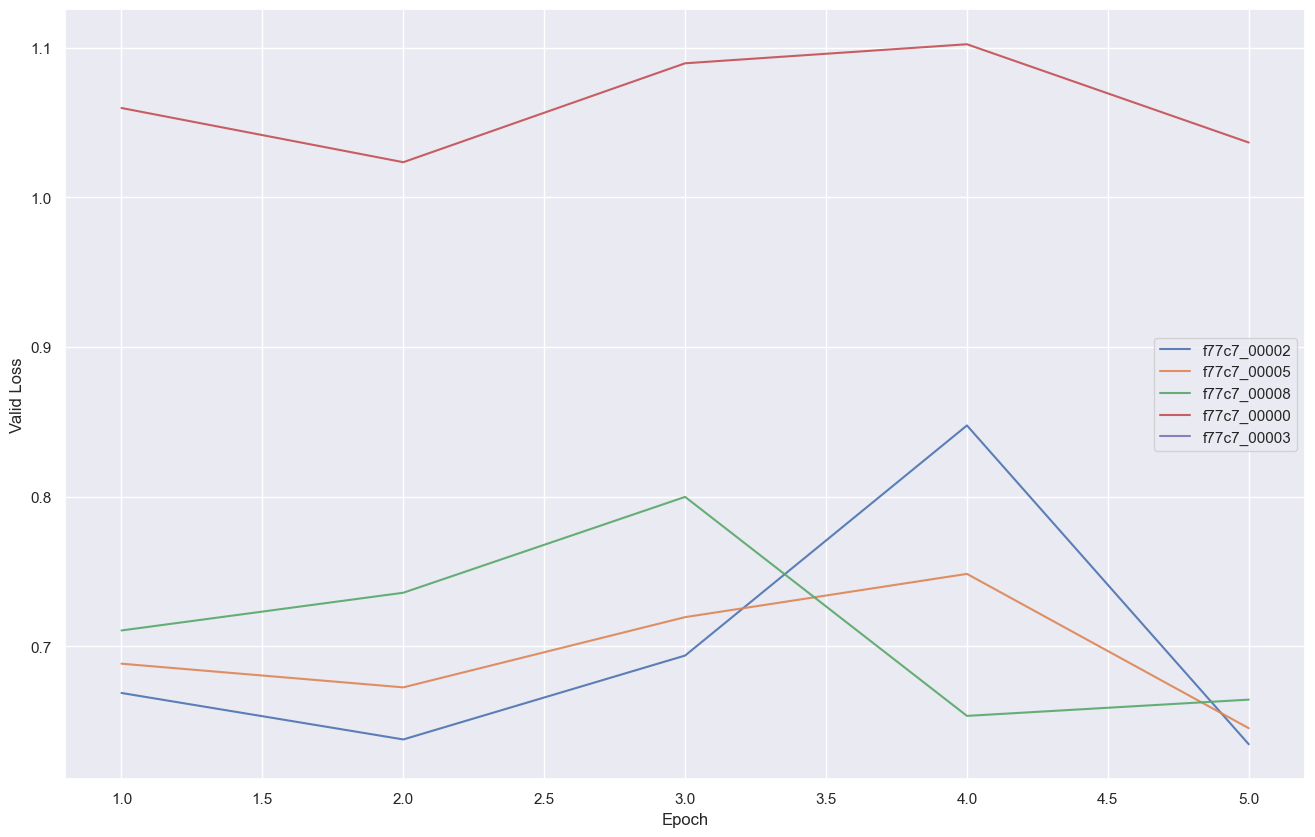

In [18]:
# Plot trials valid loss

raytune_plot.trials_lineplot_loss(
	dataframe  = trials,
	max_trials = 5,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

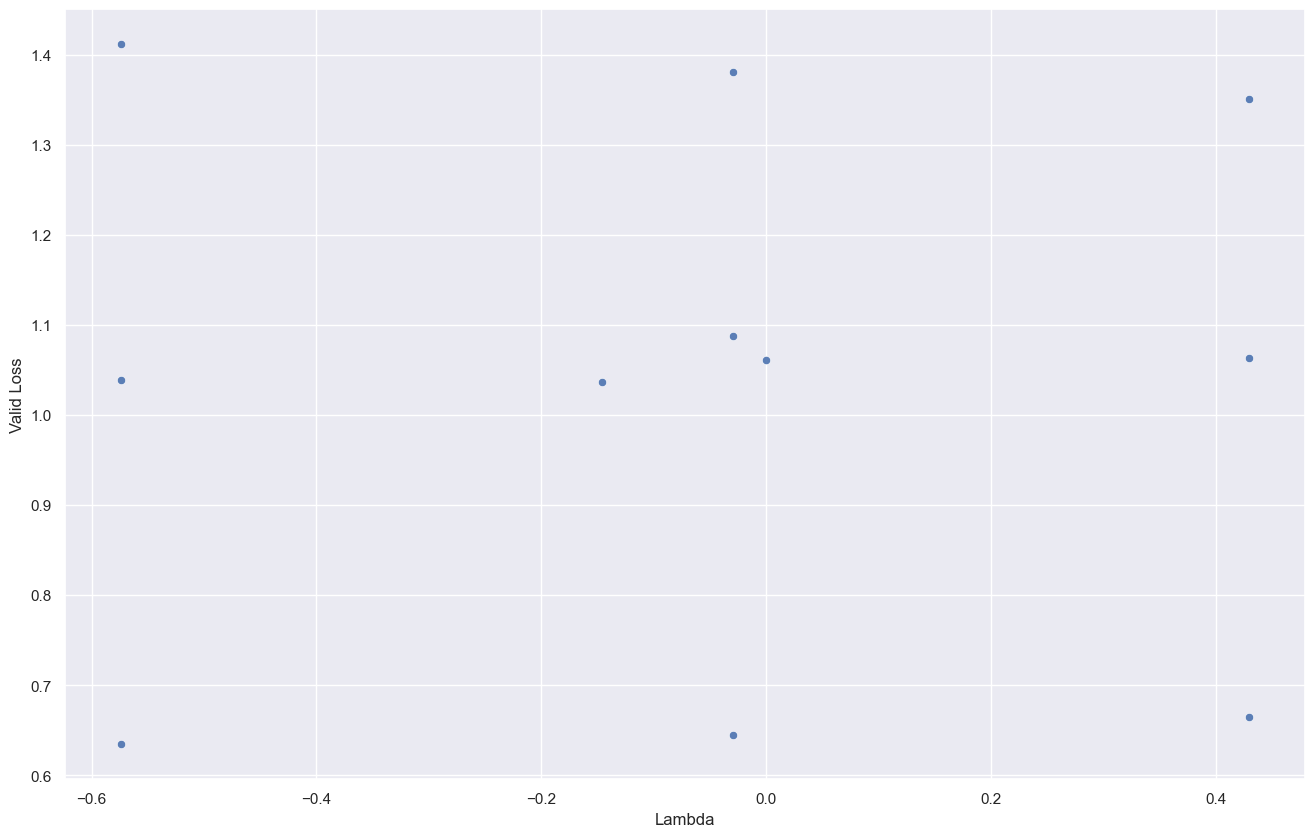

In [19]:
# Plot trials boxcox lambda vs. valid loss; clip loss values to range to bypass extreme values that would descale the plot

raytune_plot.trials_scatterplot_lambda_loss(
	dataframe = dataframe,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
	clip       = None
)

### 5.1.1 Regression

In [20]:
# Plot trials valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_lineplot_r2(
		dataframe  = trials,
		max_trials = 5,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

In [21]:
# Plot trials boxcox lambda vs. valid r2; clip r2 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_r2(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = (-2.0, None)
	)

In [22]:
# Plot trials boxcox lambda vs. valid mape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_mape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

In [23]:
# Plot trials boxcox lambda vs. valid wmape; clip mape values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trials_scatterplot_lambda_wmape(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

### 5.1.2 Classification

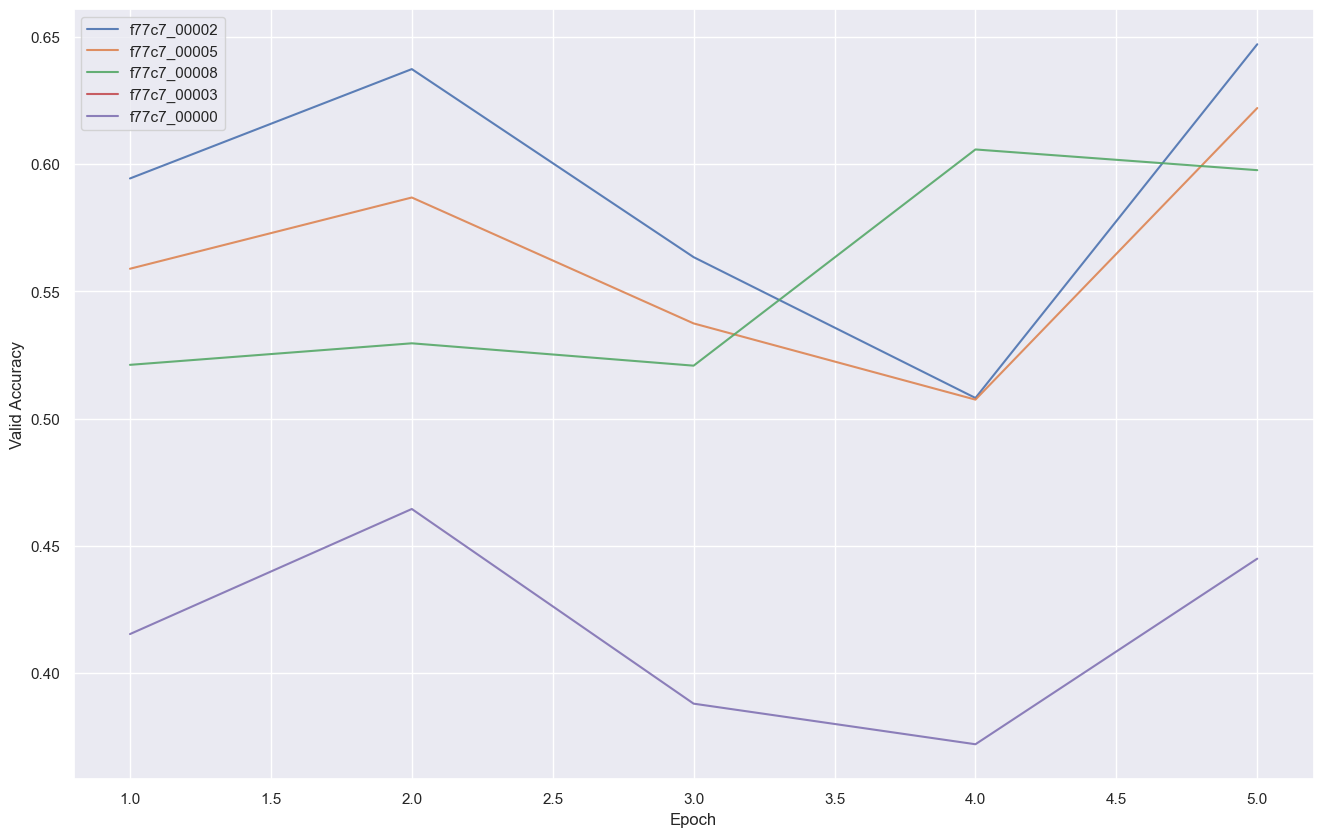

In [24]:
# Plot trials valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_lineplot_accuracy(
		dataframe  = trials,
		max_trials = 5,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

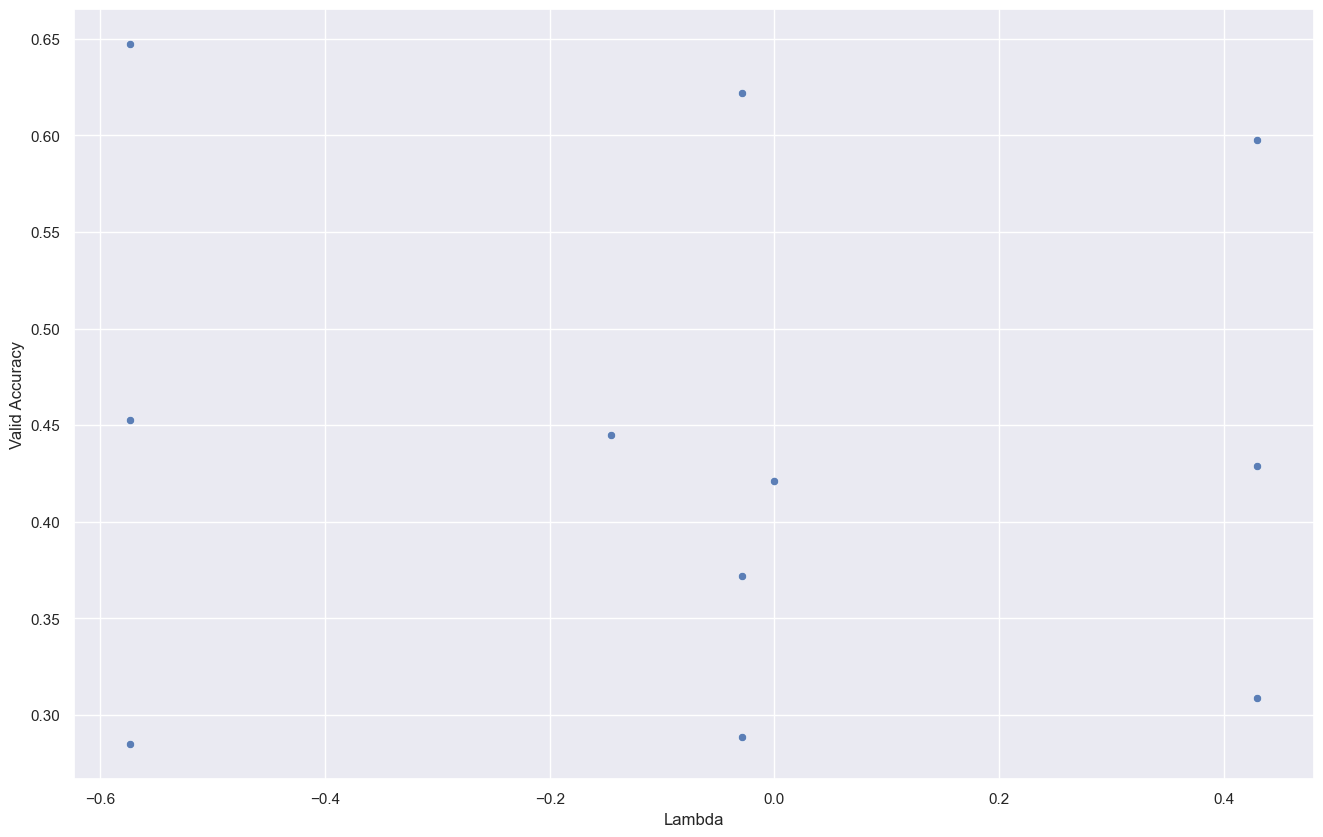

In [25]:
# Plot trials boxcox lambda vs. valid accuracy; clip accuracy values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_accuracy(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

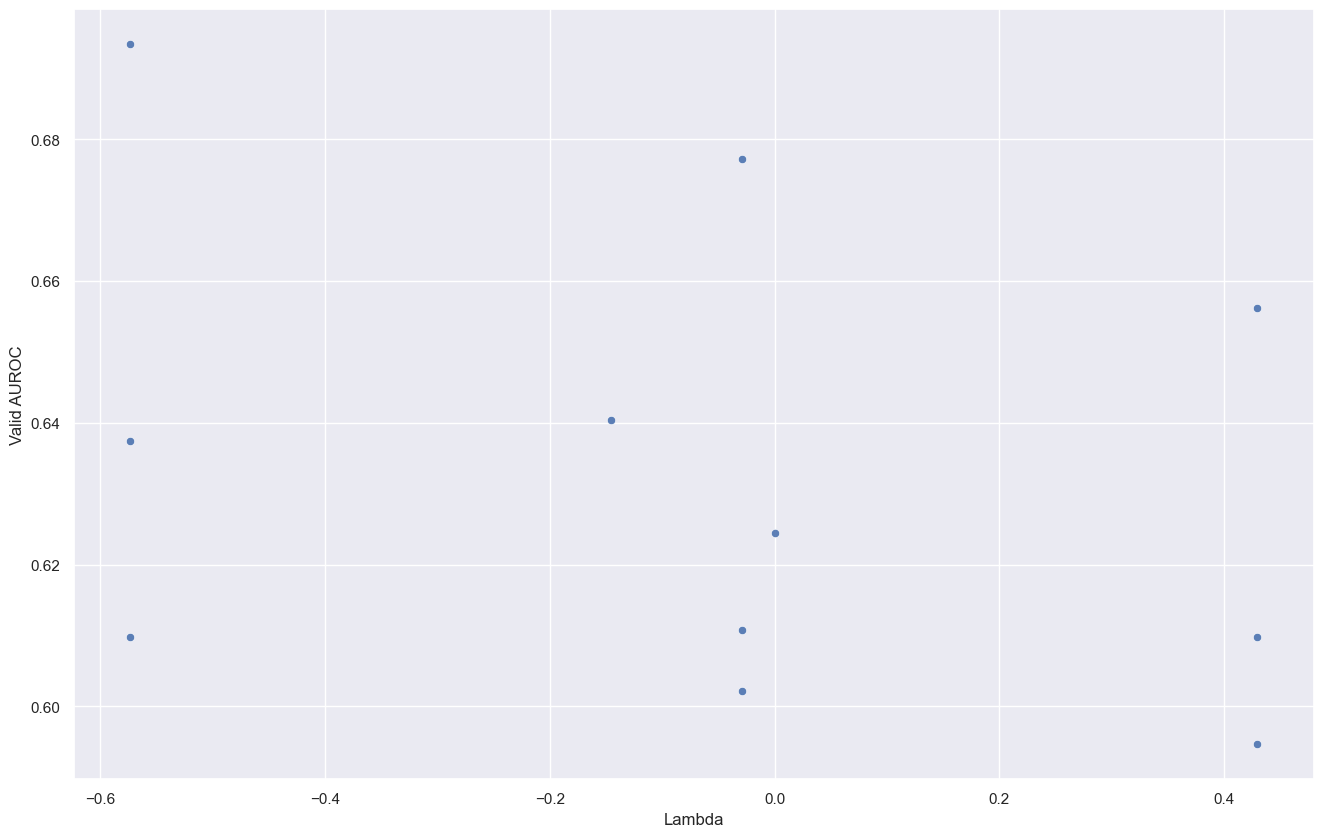

In [26]:
# Plot trials boxcox lambda vs. valid auroc; clip auroc values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_auroc(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

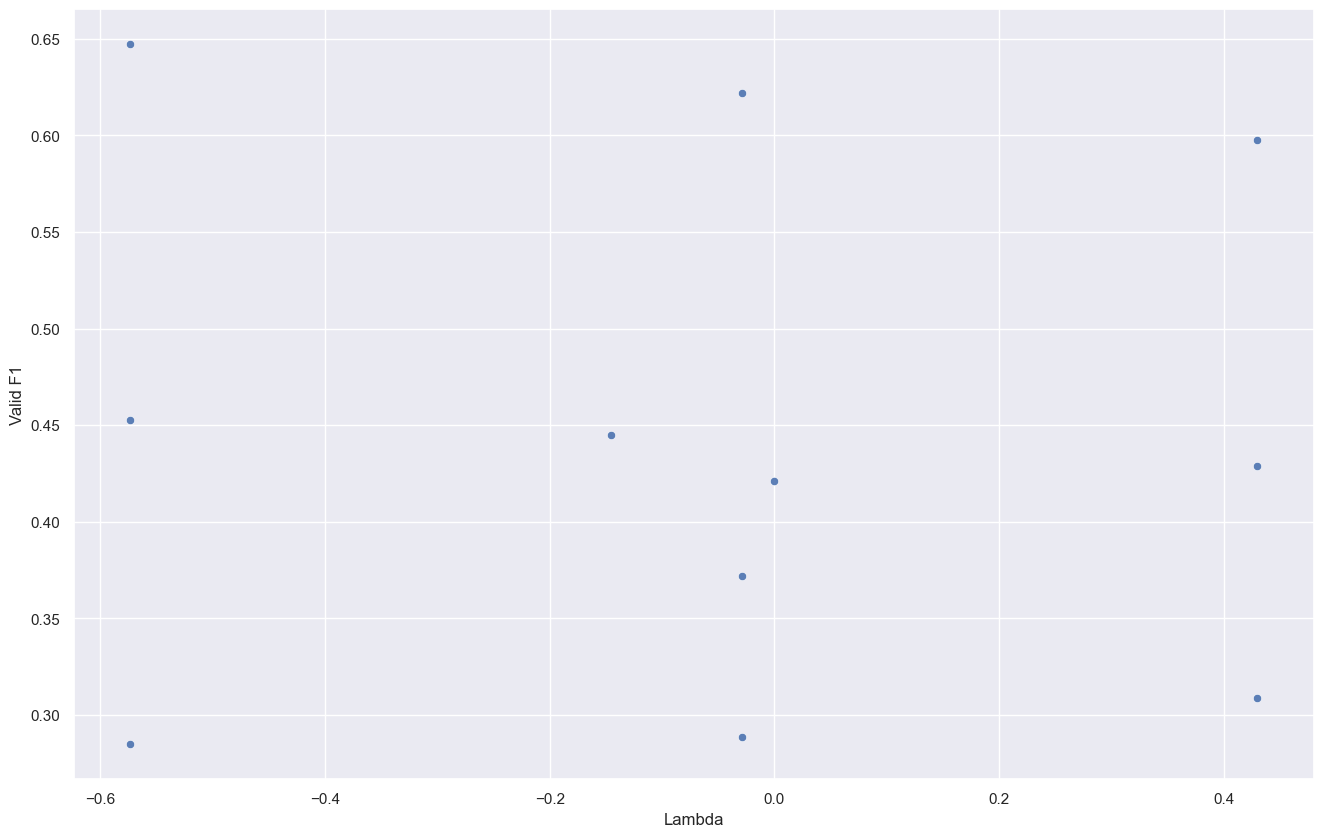

In [27]:
# Plot trials boxcox lambda vs. valid f1; clip f1 values to range to bypass extreme values that would descale the plot

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trials_scatterplot_lambda_f1(
		dataframe = dataframe,
		alpha      = 0.9,
		filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials'),
		clip       = None
	)

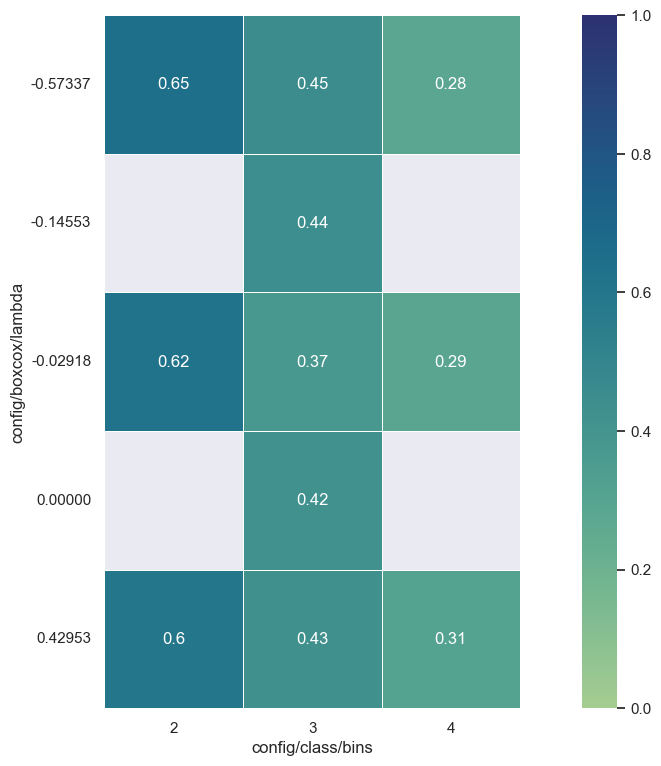

In [28]:
# Plot trials boxcox lambda vs. number of classification bins for accuracy

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_accuracy(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

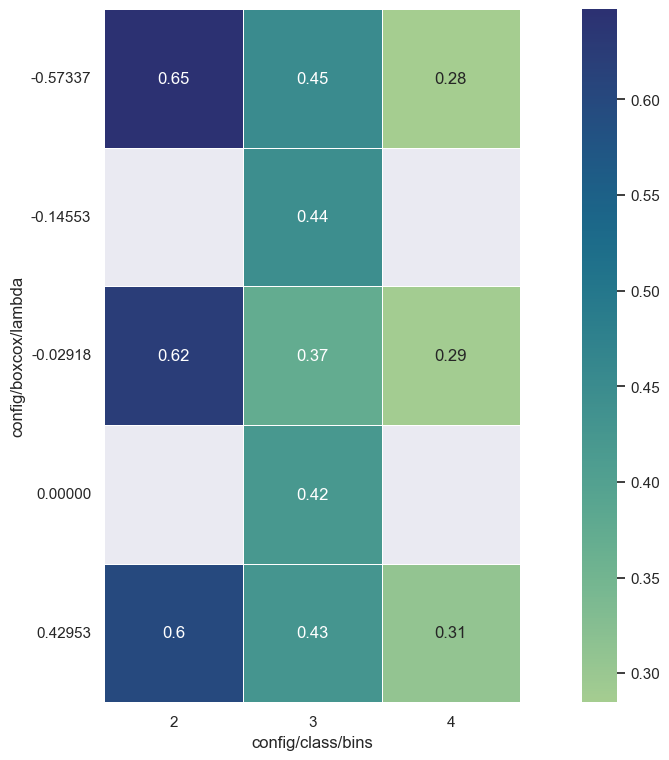

In [29]:
# Plot trials boxcox lambda vs. number of classification bins for f1

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_f1(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

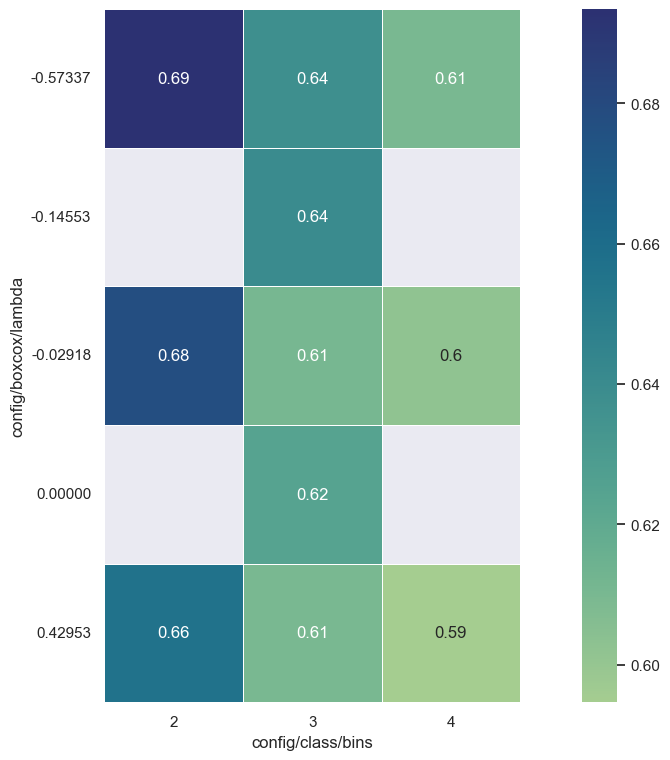

In [30]:
# Plot trials boxcox lambda vs. number of classification bins for auroc

if CONFIG['model/mode'] == 'classification' and CONFIG['tuner/search'] == 'gridsearch' :
	raytune_plot.trials_heatmap_lambda_bins_auroc(
		dataframe = dataframe,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
	)

## 5.2 Best

In [31]:
# Display best trial

best = report.get_best_result()

if CONFIG['model/mode'] == 'regression'     :
	print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))

if CONFIG['model/mode'] == 'classification' :
	print('Best metric : loss = {: 8.5f} acc = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_accuracy']))

print('Best config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Best metric : loss =  0.63459 acc =  0.64714
Best config : 
"boxcox/lambda"                : -0.5733689403178106
"class/bins"                   : 2


In [32]:
# Display per iteration

progress = loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

if CONFIG['model/mode'] == 'regression' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_r2', 'train_mae', 'train_mape', 'train_wmape',
		'valid_loss', 'valid_r2', 'valid_mae', 'valid_mape', 'valid_wmape',
	]]

if CONFIG['model/mode'] == 'classification' :
	progress = progress[[
		'trial_id', 'time_total_s', 'training_iteration', 'lr',
		'train_loss', 'train_accuracy', 'train_auroc', 'train_f1',
		'valid_loss', 'valid_accuracy', 'valid_auroc', 'valid_f1'
	]]

progress

,trial_id,time_total_s,training_iteration,lr,train_loss,train_accuracy,train_auroc,train_f1,valid_loss,valid_accuracy,valid_auroc,valid_f1
0,f77c7_00002,374.652,1,0.001,0.715,0.574,0.606,0.574,0.669,0.594,0.654,0.594
1,f77c7_00002,419.756,2,0.001,0.647,0.624,0.676,0.624,0.638,0.637,0.683,0.637
2,f77c7_00002,464.885,3,0.001,0.642,0.629,0.684,0.629,0.694,0.563,0.658,0.563
3,f77c7_00002,509.973,4,0.001,0.640,0.629,0.689,0.629,0.848,0.508,0.662,0.508
4,f77c7_00002,555.371,5,0.001,0.635,0.638,0.695,0.638,0.635,0.647,0.693,0.647


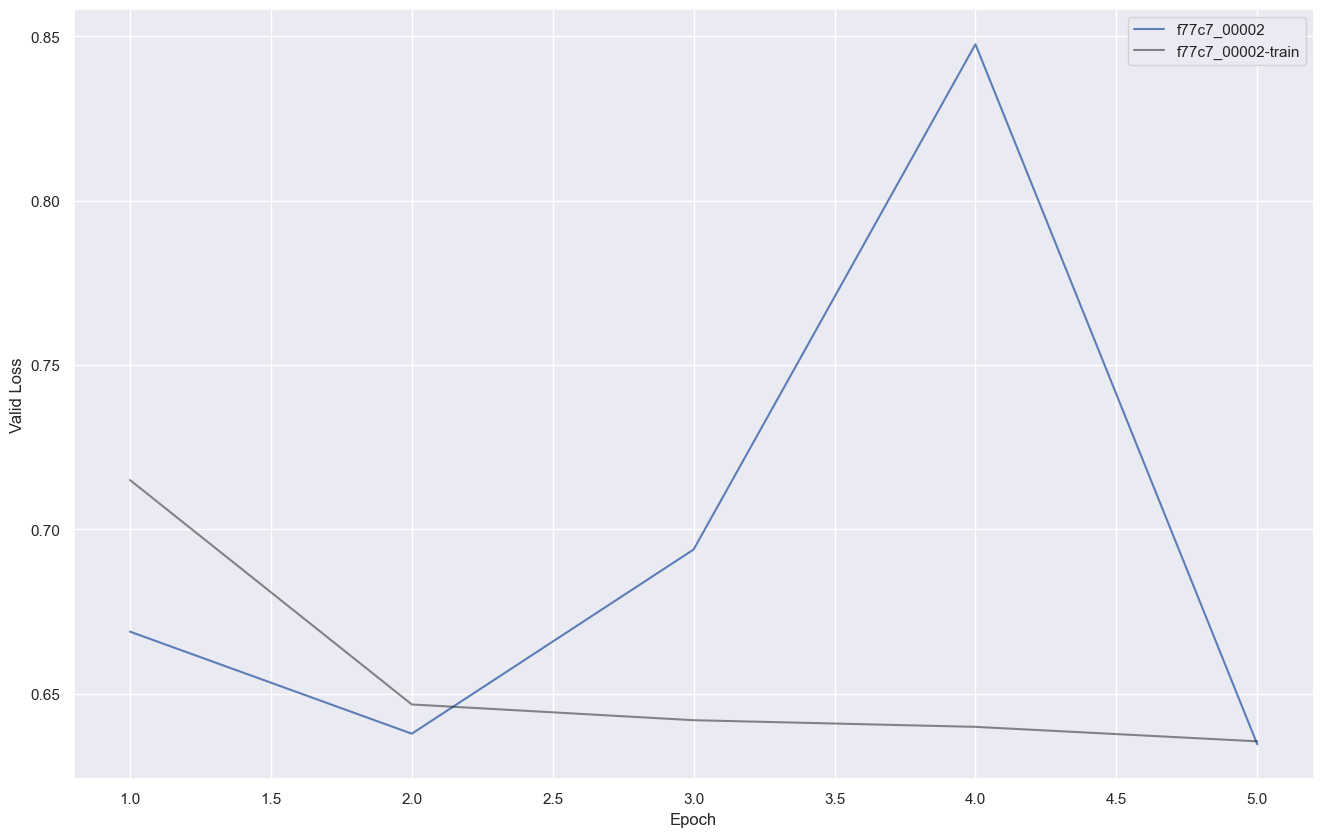

In [33]:
# Plot best trial valid loss

raytune_plot.trial_lineplot_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

In [34]:
# Plot best trial valid r2

if CONFIG['model/mode'] == 'regression' :
	raytune_plot.trial_lineplot_r2(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

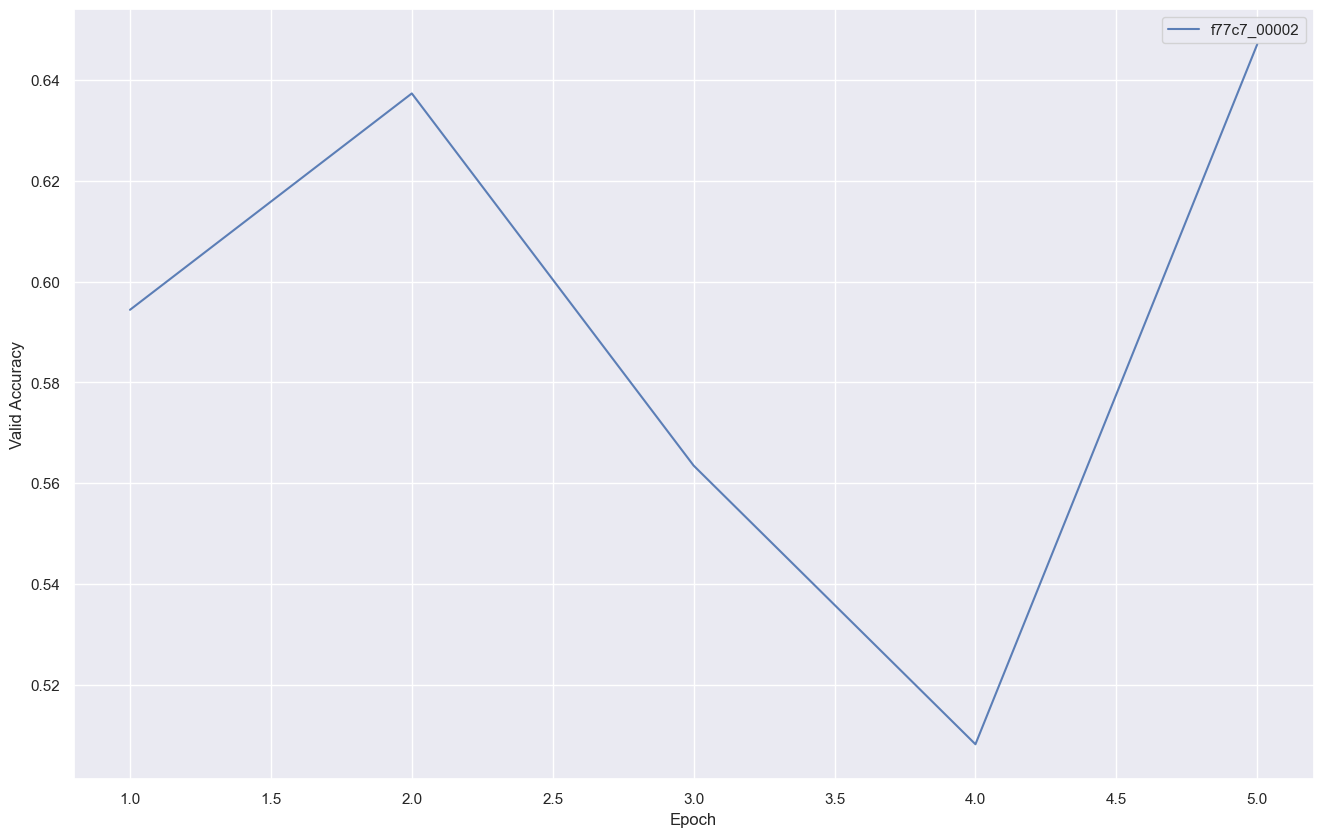

In [35]:
# Plot best trial valid accuracy

if CONFIG['model/mode'] == 'classification' :
	raytune_plot.trial_lineplot_accuracy(
		dataframe = progress,
		filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
	)

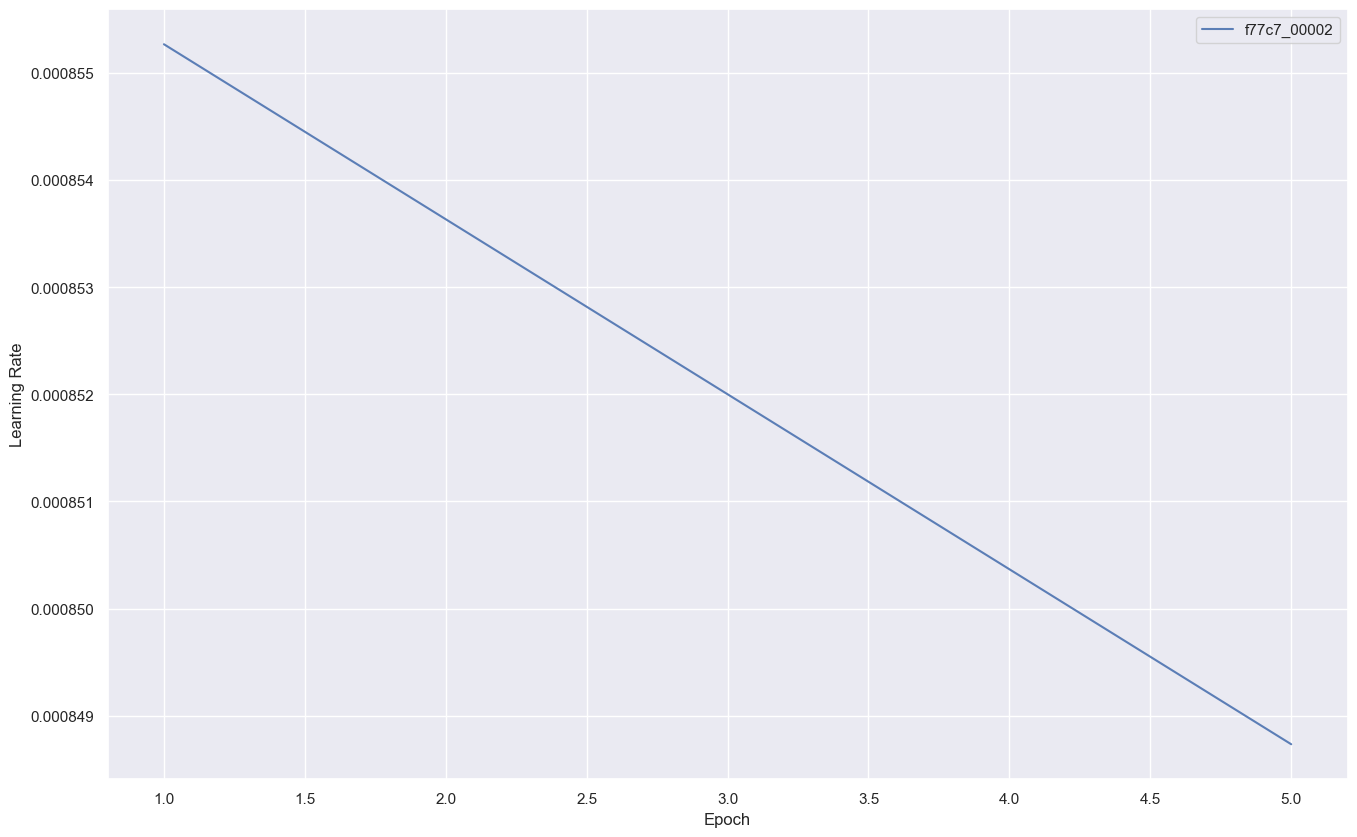

In [36]:
# Plot trials learning rate

raytune_plot.trial_lineplot_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)